# FBT Entertainment Expense Classification Pipeline
## Rabobank Australia - FBT Year Ended 31 March 2025

### Pipeline Features:
- Comprehensive data cleaning and preprocessing
- Location extraction and geocoding
- Travel distance and time estimation
- Advanced text feature engineering
- Supervised classification using ME? Y/N labels
- Optional unsupervised clustering for pattern discovery
- Multiple model comparison with hyperparameter tuning

---

## 1. Configuration

In [1]:
# =============================================================================
# CONFIGURATION
# =============================================================================

CONFIG = {
    # File paths
    'raw_data_path': 'data/data_raw_2024-25.xlsx',
    'wp_files': [
        'data/WP_1_Apr_to_Dec_24_FBT_ent_acc.xlsx',
        'data/WP_2_Apr_to_Dec_24_FBT_ent_acc.xlsx',
        'data/WP_3_Jan_to_Mar_25_FBT_ent_acc.xlsx',
        'data/WP_4_Jan_to_Mar_25_FBT_ent_acc.xlsx'
    ],
    
    # Classification mode: 'supervised' or 'unsupervised'
    'mode': 'supervised',
    
    # Enable/disable features
    'enable_clustering': True,
    
    # Clustering settings
    'n_clusters': 8,
    
    # Model training
    'test_size': 0.2,
    'random_state': 42,
    'cv_folds': 5,
    
    # Text vectorization
    'max_features': 5000,
    'ngram_range': (1, 3),
    'min_df': 2,
    'max_df': 0.95,
    
    # Output paths
    'model_output': 'fbt_classifier_pipeline.joblib',
    'encoder_output': 'fbt_label_encoder.joblib',
    'predictions_output': 'fbt_predictions.csv'
}

## 2. Imports and Setup

In [2]:
import pandas as pd
import numpy as np
import re
import warnings
from collections import Counter
from typing import List, Dict, Tuple, Optional
import math
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Text processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Model selection
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold,
    GridSearchCV, RandomizedSearchCV, learning_curve
)

# Supervised models
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier,
    BaggingClassifier, StackingClassifier
)
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

# Unsupervised models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.manifold import TSNE

# Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, f1_score,
    ConfusionMatrixDisplay, roc_curve, precision_recall_curve,
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)

# Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Imbalanced learning
try:
    from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler, TomekLinks
    from imblearn.combine import SMOTETomek
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("Note: imbalanced-learn not installed. Run: pip install imbalanced-learn")

# Model persistence
import joblib

print("All imports successful")
print(f"imbalanced-learn available: {IMBLEARN_AVAILABLE}")

All imports successful
imbalanced-learn available: True


## 3. Australian Location Database

In [3]:
# =============================================================================
# AUSTRALIAN LOCATIONS DATABASE
# Pre-defined coordinates to avoid excessive API calls
# =============================================================================

from location_extraction import AUSTRALIAN_LOCATIONS

print(f"Loaded {len(AUSTRALIAN_LOCATIONS)} locations in database")

Loaded 174 locations in database


## 4. Location Extraction and Geocoding

In [4]:
import time
from location_extraction import (
    LocationExtractor,
    LocationExtractionStrategy,
    GeocodingStrategy,
    DatabaseGeocodingStrategy,
    ChainedGeocodingStrategy,
    GoogleSearchGeocodingStrategy,
    NominatimGeocodingStrategy,
    GazetteerRegexStrategy,
    SklearnBoWStrategy,
    SklearnTfidfStrategy,
    AhoCorasickStrategy,
    RapidFuzzFuzzyStrategy,
    PhoneticGazetteerStrategy,
    SpacyNerStrategy,
)

In [14]:
available: List[tuple[str, LocationExtractionStrategy]] = []
skipped: List[tuple[str, str]] = []


def try_add(name, ctor):
    try:
        s = ctor()
        available.append((name, s))
    except Exception as e:
        skipped.append((name, str(e)))


def run_benchmark(
    strategies: List[tuple[str, LocationExtractionStrategy]],
    texts: List[str],
    repeats: int = 3,
    geocoding_strategy: Optional[GeocodingStrategy] = None,
) -> pd.DataFrame:
    """
    Benchmark location extraction speed and match count.
    - If `geocoding_strategy` is None: measures pure extraction via `strategy.extract(text)`.
    - If provided: measures end-to-end using `LocationExtractor(strategy, geocoding_strategy)`
      and counts `locations_found`.
    """
    rows = []
    if geocoding_strategy is None:
        for name, strat in strategies:
            # Warm-up
            _ = [strat.extract(t) for t in texts]
            # Timed runs
            start = time.perf_counter()
            total_found = 0
            for _ in range(repeats):
                for t in texts:
                    total_found += len(strat.extract(t))
            dur_ms = (time.perf_counter() - start) * 1000
            rows.append({
                "strategy": name,
                "texts": len(texts),
                "repeats": repeats,
                "total_matches": total_found,
                "time_ms": dur_ms,
                "time_per_run_ms": dur_ms / (len(texts) * repeats),
            })
    else:
        for name, strat in strategies:
            # Build end-to-end extractor
            loc_extractor = LocationExtractor(strategy=strat, geocoding_strategy=geocoding_strategy)
            # Warm-up
            _ = [loc_extractor.extract_location_features(t) for t in texts]
            # Timed runs
            start = time.perf_counter()
            total_found = 0
            for _ in range(repeats):
                for t in texts:
                    feats = loc_extractor.extract_location_features(t)
                    total_found += int(feats.get("locations_found", 0) or 0)
            dur_ms = (time.perf_counter() - start) * 1000
            rows.append({
                "strategy": name,
                "texts": len(texts),
                "repeats": repeats,
                "total_matches": total_found,
                "time_ms": dur_ms,
                "time_per_run_ms": dur_ms / (len(texts) * repeats),
            })
    return pd.DataFrame(rows).sort_values(["total_matches"])


def test_location_extraction(
    available: List[tuple[str, LocationExtractionStrategy]],
    geocoding_strategy: GeocodingStrategy,
    texts: List[str],
) -> pd.DataFrame:
    # Test location extraction
    output: List[dict] = []

    for name, strategy in available:
        loc_extractor = LocationExtractor(strategy=strategy, geocoding_strategy=geocoding_strategy)
        for text in texts:
            features = loc_extractor.extract_location_features(text)
            output.append({
                "text": text,
                "strategy_name": name,
                "location": features['primary_location'],
                "distance_kms": features['distance_from_ref_km'],
                "travel_time_hrs": features['estimated_travel_hours'],
                "category": features['travel_category'],
            })
    return pd.DataFrame(output)

In [ ]:
# Always include regex gazetteer
try_add("GazetteerRegex (Basic)", lambda: GazetteerRegexStrategy(locations_db=AUSTRALIAN_LOCATIONS))

# Offline dictionary-based strategies
try_add("AhoCorasick", lambda: AhoCorasickStrategy(locations_db=AUSTRALIAN_LOCATIONS))
try_add("RapidFuzz", lambda: RapidFuzzFuzzyStrategy(locations_db=AUSTRALIAN_LOCATIONS, threshold=85))
try_add("Phonetic", lambda: PhoneticGazetteerStrategy(locations_db=AUSTRALIAN_LOCATIONS, min_token_match_ratio=0.6))

try_add("SklearnBoW (Count Vectorizer)", lambda: SklearnBoWStrategy(
    locations_db=AUSTRALIAN_LOCATIONS,
    vectorizer=CountVectorizer(analyzer='word', ngram_range=(1,3), min_df=1)
))
try_add("SklearnTfidf (TF-IDF Vectorizer)", lambda: SklearnTfidfStrategy(
    locations_db=AUSTRALIAN_LOCATIONS,
    vectorizer=TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df=1)
))
try_add("SpacyNER (Small Model)", lambda: SpacyNerStrategy(
    locations_db=AUSTRALIAN_LOCATIONS,
    model_name="en_core_web_sm",
    models_preference=[
                "en_core_web_sm",
            ]))

try_add("SpacyNER (Transformer Pipeline Model)", lambda: SpacyNerStrategy(
    locations_db=AUSTRALIAN_LOCATIONS,
    model_name="en_core_web_trf",
    models_preference=[
                "en_core_web_trf",
            ]))
# Database normalization: keys lowercased, lat/lon to floats
db = DatabaseGeocodingStrategy(locations_db=AUSTRALIAN_LOCATIONS)

# Nominatim (OpenStreetMap) - requires internet
nom = NominatimGeocodingStrategy(country_hint="Australia")

# Chained: drops None entries, preserves order
chain = ChainedGeocodingStrategy(strategies=[db, nom])
# print('Chained geocode sydney ->', chain.geocode('sydney') is not None)

# Google wrapper inherits locations_db from inner if not provided
# goog = GoogleSearchGeocodingStrategy(inner=db)
# print('Google inherited DB ->', isinstance(goog.locations_db, dict))

# Sample texts for quick comparison (can be replaced with dataset rows)
SAMPLE_TEXTS = [
    "Flight to Brisbane for client meeting",
    "Dinner at Roma with clients - Board Members Visit",
    "Trip to Utrecht for Global General Counsel Offsite",
    "Taxi to airport for Sydney trip",
    "Team lunch at local restaurant",
    "Travel to Dubbo for farm visit",
    "Client dinner in Melbourne CBD",
    "Team dinner at The Rocks Sydney after client meeting.",
    "Taxi from Melbourne CBD to Tullamarine airport.",
    "Hotel stay Brisbane for conference.",
    "Client visit in Dubbo NSW, return to Sydney.",
    "Flight to Perth WA for site inspection.",
    "Meeting in Adelaide SA, lunch nearby.",
]

df_bm_all = run_benchmark(available, SAMPLE_TEXTS, repeats=5, geocoding_strategy=chain)
print("Strategy Benchmark (lower time is better):")
display(df_bm_all)

print("Included strategies:", [n for n,_ in available])
if skipped:
    print("Skipped strategies (reason):")
    for n, r in skipped:
        print(" -", n, "->", r)

# df_location_features = test_location_extraction(available, db, SAMPLE_TEXTS)
# print("Location Extraction Results:")
# display(df_location_features)

## 5. Data Loading

In [6]:
def load_raw_data(filepath: str) -> pd.DataFrame:
    """
    Load raw transaction data from all sheets.
    """
    print(f"Loading raw data from: {filepath}")
    xl = pd.ExcelFile(filepath)
    print(f"Found {len(xl.sheet_names)} sheets")
    
    dfs = []
    for sheet in xl.sheet_names:
        df = pd.read_excel(filepath, sheet_name=sheet)
        df['_source_sheet'] = sheet
        dfs.append(df)
        print(f"  - {sheet}: {len(df)} rows")
    
    combined = pd.concat(dfs, ignore_index=True)
    print(f"\nTotal: {len(combined)} rows")
    return combined


def parse_workpaper(filepath: str, sheet_name: str) -> Optional[pd.DataFrame]:
    """
    Parse a workpaper sheet to extract labeled transactions.
    """
    try:
        df = pd.read_excel(filepath, sheet_name=sheet_name, header=None)
        
        # Find header row
        header_idx = None
        for i, row in df.iterrows():
            row_str = ' '.join([str(v).upper() for v in row.values if pd.notna(v)])
            if 'BUSINESS_UNIT_CODE' in row_str:
                header_idx = i
                break
        
        if header_idx is None:
            return None
        
        # Set headers
        headers = df.iloc[header_idx].tolist()
        headers = [str(h).strip() if pd.notna(h) else f'_col_{i}' for i, h in enumerate(headers)]
        
        data = df.iloc[header_idx + 1:].copy()
        data.columns = headers
        
        # Find label columns
        col_mapping = {}
        for col in headers:
            col_lower = str(col).lower()
            if 'tax' in col_lower and 'desc' in col_lower:
                col_mapping[col] = 'tax_description'
            elif 'me?' in col_lower:
                col_mapping[col] = 'me_label'
        
        data = data.rename(columns=col_mapping)
        data['_source_file'] = filepath.split('/')[-1]
        data['_source_sheet'] = sheet_name
        
        return data
    except Exception as e:
        print(f"  Error: {e}")
        return None


def load_labeled_data(wp_files: List[str]) -> pd.DataFrame:
    """
    Load labeled data from all workpapers.
    """
    all_dfs = []
    
    for filepath in wp_files:
        print(f"\nProcessing: {filepath}")
        try:
            xl = pd.ExcelFile(filepath)
            for sheet in xl.sheet_names:
                if any(skip in sheet.lower() for skip in ['summary', 'trial balance']):
                    continue
                
                df = parse_workpaper(filepath, sheet)
                if df is not None and len(df) > 0:
                    has_me = 'me_label' in df.columns
                    print(f"  - {sheet}: {len(df)} rows (has labels: {has_me})")
                    all_dfs.append(df)
        except Exception as e:
            print(f"  Error: {e}")
    
    if not all_dfs:
        return pd.DataFrame()
    
    combined = pd.concat(all_dfs, ignore_index=True)
    print(f"\nTotal labeled: {len(combined)} rows")
    return combined

In [7]:
# Load data
raw_data = load_raw_data(CONFIG['raw_data_path'])
labeled_data = load_labeled_data(CONFIG['wp_files'])

Loading raw data from: data/data_raw_2024-25.xlsx
Found 14 sheets
Found 14 sheets
  - 5130006000: 224 rows
  - 5130006000: 224 rows
  - 5130002000: 4347 rows
  - 5130002000: 4347 rows
  - 5130005000: 3673 rows
  - 5130005000: 3673 rows
  - 5130004000: 27108 rows
  - 5130004000: 27108 rows
  - 5130001000: 3097 rows
  - 5130001000: 3097 rows
  - 5130003000: 1165 rows
  - 5130003000: 1165 rows
  - 5140001010: 349 rows
  - 5140001010: 349 rows
  - 5140001030: 114 rows
  - 5140001030: 114 rows
  - 5160001000: 570 rows
  - 5160001000: 570 rows
  - 5160007000: 76 rows
  - 5160007000: 76 rows
  - 5160008000: 48 rows
  - 5160008000: 48 rows
  - 5160010000: 247 rows
  - 5160010000: 247 rows
  - 5160011000: 1311 rows
  - 5160011000: 1311 rows
  - Misc: 5062 rows

Total: 47391 rows

Processing: data/WP_1_Apr_to_Dec_24_FBT_ent_acc.xlsx
  - Misc: 5062 rows

Total: 47391 rows

Processing: data/WP_1_Apr_to_Dec_24_FBT_ent_acc.xlsx
  - Travel&lodging: 33218 rows (has labels: True)
  - Travel&lodging: 33

## 6. Data Cleaning

In [8]:
class DataCleaner:
    """
    Comprehensive data cleaning.
    """
    
    def __init__(self):
        self.stats = {}
    
    def standardize_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df = df.loc[:, ~df.columns.str.contains('^Unnamed|^_col_', case=False, na=False)]
        
        new_cols = []
        for col in df.columns:
            new_col = str(col).strip()
            new_col = re.sub(r'\s+', '_', new_col)
            new_col = re.sub(r'[^a-zA-Z0-9_]', '', new_col)
            new_col = new_col.upper()
            new_cols.append(new_col)
        
        df.columns = new_cols
        return df
    
    def clean_text(self, series: pd.Series) -> pd.Series:
        series = series.fillna('').astype(str).str.strip()
        series = series.str.replace(r'\s+', ' ', regex=True)
        series = series.replace(['nan', 'NaN', 'None', ''], np.nan)
        return series
    
    def clean_me_label(self, series: pd.Series) -> pd.Series:
        series = series.fillna('').astype(str).str.strip().str.upper()
        mapping = {
            'Y': 'Y', 'YES': 'Y', '1': 'Y', 'TRUE': 'Y',
            'N': 'N', 'NO': 'N', '0': 'N', 'FALSE': 'N'
        }
        return series.map(lambda x: mapping.get(x, np.nan))
    
    def clean(self, df: pd.DataFrame) -> pd.DataFrame:
        print(f"Cleaning {len(df)} rows...")
        initial = len(df)
        
        df = self.standardize_columns(df)
        
        # Clean text columns
        text_cols = ['PURPOSE', 'CHARGE_DESCRIPTION', 'LINE_DESCR', 
                     'DESCRIPTION', 'INVOICE_DESCR', 'VENDOR_NAME', 'DESCR']
        for col in text_cols:
            if col in df.columns:
                df[col] = self.clean_text(df[col])
        
        # Clean numeric
        if 'BASE_AMOUNT' in df.columns:
            df['BASE_AMOUNT'] = pd.to_numeric(df['BASE_AMOUNT'], errors='coerce')
        
        # Clean dates
        if 'JOURNAL_DATE' in df.columns:
            df['JOURNAL_DATE'] = pd.to_datetime(df['JOURNAL_DATE'], errors='coerce')
        
        # Clean labels
        if 'ME_LABEL' in df.columns:
            df['ME_LABEL'] = self.clean_me_label(df['ME_LABEL'])
        if 'me_label' in df.columns:
            df['me_label'] = self.clean_me_label(df['me_label'])
        
        # Remove duplicates
        dedup_cols = ['BUSINESS_UNIT_CODE', 'ACCOUNT_CODE', 'BASE_AMOUNT', 'JOURNAL_DATE']
        available = [c for c in dedup_cols if c in df.columns]
        if available:
            df = df.drop_duplicates(subset=available, keep='first')
        
        # Remove rows with all empty text
        available_text = [c for c in text_cols if c in df.columns]
        if available_text:
            mask = df[available_text].notna().any(axis=1)
            df = df[mask]
        
        print(f"Cleaned: {len(df)} rows (removed {initial - len(df)})")
        return df

In [10]:
cleaner = DataCleaner()
raw_data_clean = cleaner.clean(raw_data.copy())
labeled_data_clean = cleaner.clean(labeled_data.copy())

Cleaning 47391 rows...
Cleaned: 33616 rows (removed 13775)
Cleaning 109034 rows...
Cleaned: 33616 rows (removed 13775)
Cleaning 109034 rows...
Cleaned: 33678 rows (removed 75356)
Cleaned: 33678 rows (removed 75356)


In [11]:
# Check label distribution
print("\nLabel Distribution:")
print("=" * 40)

me_col = 'me_label' if 'me_label' in labeled_data_clean.columns else 'ME_LABEL'
if me_col in labeled_data_clean.columns:
    print(f"\n{me_col}:")
    print(labeled_data_clean[me_col].value_counts(dropna=False))

tax_col = 'tax_description' if 'tax_description' in labeled_data_clean.columns else 'TAX_DESCRIPTION'
if tax_col in labeled_data_clean.columns:
    print(f"\nTop 15 {tax_col}:")
    print(labeled_data_clean[tax_col].value_counts().head(15))


Label Distribution:

ME_LABEL:
ME_LABEL
NaN    29790
Y       3469
N        419
Name: count, dtype: int64

Top 15 TAX_DESCRIPTION:
TAX_DESCRIPTION
ME                                               2589
Accept travel meal                               1183
business expense                                  760
No FBT, Tax deductible                            590
Dinner                                            478
Business expense                                  290
office consumables - OK                           224
OK - business expense                             201
ME - no workplace                                 146
OK                                                130
office consumables                                128
business expense - ok                             121
Office consumables                                117
accept - sustenance on premises - light lunch     114
Alcohol                                            66
Name: count, dtype: int64


## 7. Feature Engineering

In [12]:
class FeatureEngineer:
    """
    Comprehensive feature engineering.
    """
    
    def __init__(self):
        self.location_extractor = LocationExtractor()
    
    def create_combined_text(self, df: pd.DataFrame) -> pd.Series:
        text_cols = ['PURPOSE', 'CHARGE_DESCRIPTION', 'LINE_DESCR',
                     'DESCRIPTION', 'INVOICE_DESCR', 'VENDOR_NAME', 'DESCR']
        available = [c for c in text_cols if c in df.columns]
        
        def combine(row):
            parts = [str(row.get(c, '')).strip() for c in available 
                     if pd.notna(row.get(c)) and str(row.get(c)).strip()]
            return ' '.join(parts)
        
        combined = df.apply(combine, axis=1)
        
        # Clean text
        combined = combined.str.lower()
        combined = combined.str.replace(r'[^a-z0-9\s]', ' ', regex=True)
        combined = combined.str.replace(r'\s+', ' ', regex=True).str.strip()
        
        return combined
    
    def extract_amount_features(self, df: pd.DataFrame) -> pd.DataFrame:
        features = pd.DataFrame(index=df.index)
        
        if 'BASE_AMOUNT' in df.columns:
            amt = df['BASE_AMOUNT'].fillna(0)
            features['amount'] = amt
            features['amount_abs'] = np.abs(amt)
            features['amount_log'] = np.log1p(np.abs(amt))
            features['amount_is_negative'] = (amt < 0).astype(int)
            features['amount_is_round_100'] = (amt % 100 == 0).astype(int)
            features['amount_is_round_50'] = (amt % 50 == 0).astype(int)
            
            # Buckets
            features['amount_bucket'] = pd.cut(
                np.abs(amt),
                bins=[-np.inf, 50, 100, 200, 300, 500, 1000, 5000, np.inf],
                labels=['0-50', '50-100', '100-200', '200-300', '300-500', 
                        '500-1000', '1000-5000', '5000+']
            ).astype(str)
        
        return features
    
    def extract_date_features(self, df: pd.DataFrame) -> pd.DataFrame:
        features = pd.DataFrame(index=df.index)
        
        if 'JOURNAL_DATE' in df.columns:
            dates = pd.to_datetime(df['JOURNAL_DATE'], errors='coerce')
            features['month'] = dates.dt.month.fillna(0).astype(int)
            features['day_of_week'] = dates.dt.dayofweek.fillna(0).astype(int)
            features['day_of_month'] = dates.dt.day.fillna(0).astype(int)
            features['quarter'] = dates.dt.quarter.fillna(0).astype(int)
            features['is_weekend'] = dates.dt.dayofweek.isin([5, 6]).astype(int)
            features['is_month_end'] = (dates.dt.day >= 25).astype(int)
            features['is_friday'] = (dates.dt.dayofweek == 4).astype(int)
            features['is_december'] = (dates.dt.month == 12).astype(int)
            features['is_fbt_q4'] = dates.dt.month.isin([1, 2, 3]).astype(int)
        
        return features
    
    def extract_account_features(self, df: pd.DataFrame) -> pd.DataFrame:
        features = pd.DataFrame(index=df.index)
        
        if 'ACCOUNT_CODE' in df.columns:
            code = df['ACCOUNT_CODE'].fillna(0).astype(int).astype(str)
            features['account_code'] = code
            features['account_group'] = code.str[:4]
            
            # Known entertainment-related accounts
            features['is_entertainment_account'] = df['ACCOUNT_CODE'].isin([5130006000]).astype(int)
            features['is_meals_account'] = df['ACCOUNT_CODE'].isin([5130004000]).astype(int)
            features['is_travel_account'] = df['ACCOUNT_CODE'].isin([5130001000, 5130002000, 5130003000, 5130005000]).astype(int)
        
        return features
    
    def extract_text_features(self, df: pd.DataFrame) -> pd.DataFrame:
        features = pd.DataFrame(index=df.index)
        combined = self.create_combined_text(df)
        
        # Length features
        features['text_length'] = combined.str.len()
        features['word_count'] = combined.str.split().str.len()
        
        # Keyword features
        keyword_groups = {
            'entertainment': ['dinner', 'lunch', 'breakfast', 'meal', 'restaurant',
                              'catering', 'entertainment', 'party', 'celebration',
                              'christmas', 'xmas', 'farewell', 'function', 'drinks',
                              'alcohol', 'wine', 'beer', 'event'],
            'travel': ['flight', 'airfare', 'taxi', 'uber', 'accommodation', 'hotel',
                       'travel', 'airport', 'parking', 'qantas', 'virgin', 'cabcharge'],
            'training': ['training', 'conference', 'seminar', 'workshop', 'course'],
            'recreation': ['team building', 'teambuilding', 'fun day', 'bowling',
                           'golf', 'sailing', 'escape room', 'activity'],
            'client': ['client', 'customer', 'partner', 'stakeholder', 'external'],
            'staff': ['staff', 'employee', 'team', 'internal', 'offsite']
        }
        
        for group, keywords in keyword_groups.items():
            pattern = '|'.join(keywords)
            features[f'has_{group}_kw'] = combined.str.contains(pattern, na=False).astype(int)
        
        return features
    
    def extract_location_features(self, df: pd.DataFrame) -> pd.DataFrame:
        print("Extracting location features...")
        combined = self.create_combined_text(df)
        
        location_features = []
        for i, text in enumerate(combined):
            if i % 5000 == 0:
                print(f"  Processing row {i}/{len(combined)}")
            features = self.location_extractor.extract_location_features(text)
            location_features.append(features)
        
        loc_df = pd.DataFrame(location_features, index=df.index)
        print(f"  Done. Found locations in {(loc_df['locations_found'] > 0).sum()} rows")
        return loc_df
    
    def engineer_all_features(self, df: pd.DataFrame) -> Tuple[pd.Series, pd.DataFrame]:
        print("\nEngineering features...")
        
        combined_text = self.create_combined_text(df)
        print(f"  Combined text created")
        
        amount_feat = self.extract_amount_features(df)
        print(f"  Amount features: {amount_feat.shape[1]}")
        
        date_feat = self.extract_date_features(df)
        print(f"  Date features: {date_feat.shape[1]}")
        
        account_feat = self.extract_account_features(df)
        print(f"  Account features: {account_feat.shape[1]}")
        
        text_feat = self.extract_text_features(df)
        print(f"  Text features: {text_feat.shape[1]}")
        
        location_feat = self.extract_location_features(df)
        print(f"  Location features: {location_feat.shape[1]}")
        
        # Combine all features
        all_features = pd.concat([
            amount_feat, date_feat, account_feat, text_feat, location_feat
        ], axis=1)
        
        print(f"\nTotal features: {all_features.shape[1]}")
        return combined_text, all_features

In [13]:
# Engineer features
feature_engineer = FeatureEngineer()
labeled_text, labeled_features = feature_engineer.engineer_all_features(labeled_data_clean)
labeled_data_clean['combined_text'] = labeled_text


Engineering features...
  Combined text created
  Amount features: 7
  Date features: 9
  Account features: 5
  Combined text created
  Amount features: 7
  Date features: 9
  Account features: 5
  Text features: 8
Extracting location features...
  Text features: 8
Extracting location features...
  Processing row 0/33678
  Processing row 5000/33678
  Processing row 0/33678
  Processing row 5000/33678
  Processing row 10000/33678
  Processing row 15000/33678
  Processing row 10000/33678
  Processing row 15000/33678
  Processing row 20000/33678
  Processing row 25000/33678
  Processing row 20000/33678
  Processing row 25000/33678
  Processing row 30000/33678
  Done. Found locations in 10883 rows
  Location features: 15

Total features: 44
  Processing row 30000/33678
  Done. Found locations in 10883 rows
  Location features: 15

Total features: 44


In [16]:
# Preview features
print("\nFeature Preview:")
print(labeled_features.head())


Feature Preview:
     amount  amount_abs  amount_log  amount_is_negative  amount_is_round_100  \
0 -35139.31    35139.31   10.467104                   1                    0   
1  35139.31    35139.31   10.467104                   0                    0   
2 -31624.51    31624.51   10.361719                   1                    0   
3   9974.00     9974.00    9.207837                   0                    0   
4  -5895.45     5895.45    8.682106                   1                    0   

   amount_is_round_50 amount_bucket  month  day_of_week  day_of_month  ...  \
0                   0         5000+     11            4            29  ...   
1                   0         5000+     11            4            29  ...   
2                   0         5000+     11            3            28  ...   
3                   0         5000+     12            3            12  ...   
4                   0         5000+     11            4            29  ...   

   primary_lon  distance_from_re

In [14]:
# Location statistics
print("\nLocation Statistics:")
print(f"Rows with locations: {(labeled_features['locations_found'] > 0).sum()}")
print(f"\nTravel Category Distribution:")
print(labeled_features['travel_category'].value_counts())
print(f"\nDistance Statistics (km):")
print(labeled_features['distance_from_ref_km'].describe())


Location Statistics:
Rows with locations: 10883

Travel Category Distribution:
travel_category
unknown          22795
remote            7023
local             1701
regional          1282
international      807
interstate          70
Name: count, dtype: int64

Distance Statistics (km):
count    10883.000000
mean      1718.175536
std       3336.831285
min          0.000000
25%        378.740000
50%        732.380000
75%       1412.750000
max      16993.930000
Name: distance_from_ref_km, dtype: float64


## 8. Prepare Training Data

In [18]:
def prepare_training_data(df: pd.DataFrame, features: pd.DataFrame, 
                          text_col: str = 'combined_text'):
    """
    Prepare data for supervised training.
    """
    # Find label column
    label_col = 'me_label' if 'me_label' in df.columns else 'ME_LABEL'
    
    # Filter valid labels
    valid_mask = df[label_col].isin(['Y', 'N'])
    df_valid = df[valid_mask].copy()
    features_valid = features[valid_mask].copy()
    
    print(f"Valid samples: {len(df_valid)}")
    print(f"Label distribution:\n{df_valid[label_col].value_counts()}")
    
    # Prepare data
    X_text = df_valid[text_col].values
    X_features = features_valid.copy()
    y = df_valid[label_col].values
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    print(f"Classes: {label_encoder.classes_}")
    
    return X_text, X_features, y_encoded, label_encoder, df_valid

In [19]:
X_text, X_features, y, label_encoder, train_df = prepare_training_data(
    labeled_data_clean, labeled_features
)

Valid samples: 3888
Label distribution:
ME_LABEL
Y    3469
N     419
Name: count, dtype: int64
Classes: ['N' 'Y']


In [20]:
# Split data
X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_text, X_features, y,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=y
)

print(f"Training: {len(X_text_train)}")
print(f"Test: {len(X_text_test)}")

Training: 3110
Test: 778


## 9. Text Vectorization

In [21]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=CONFIG['max_features'],
    ngram_range=CONFIG['ngram_range'],
    min_df=CONFIG['min_df'],
    max_df=CONFIG['max_df'],
    sublinear_tf=True,
    strip_accents='unicode',
    lowercase=True
)

X_tfidf_train = tfidf.fit_transform(X_text_train)
X_tfidf_test = tfidf.transform(X_text_test)

print(f"TF-IDF shape: {X_tfidf_train.shape}")

TF-IDF shape: (3110, 5000)


In [22]:
# Prepare numerical features
numerical_cols = X_feat_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = ['amount_bucket', 'travel_category', 'account_code', 'account_group']
categorical_cols = [c for c in categorical_cols if c in X_feat_train.columns]

print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

Numerical features: 37
Categorical features: 4


In [23]:
# Scale numerical features
scaler = StandardScaler()

X_num_train = X_feat_train[numerical_cols].fillna(0).values
X_num_test = X_feat_test[numerical_cols].fillna(0).values

X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_test_scaled = scaler.transform(X_num_test)

# Encode categorical features
if categorical_cols:
    cat_encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
    X_cat_train = cat_encoder.fit_transform(X_feat_train[categorical_cols].fillna('unknown'))
    X_cat_test = cat_encoder.transform(X_feat_test[categorical_cols].fillna('unknown'))
else:
    X_cat_train = None
    X_cat_test = None

In [24]:
# Combine all features
from scipy import sparse

feature_matrices_train = [X_tfidf_train, sparse.csr_matrix(X_num_train_scaled)]
feature_matrices_test = [X_tfidf_test, sparse.csr_matrix(X_num_test_scaled)]

if X_cat_train is not None:
    feature_matrices_train.append(X_cat_train)
    feature_matrices_test.append(X_cat_test)

X_combined_train = sparse.hstack(feature_matrices_train)
X_combined_test = sparse.hstack(feature_matrices_test)

print(f"Combined feature matrix: {X_combined_train.shape}")

Combined feature matrix: (3110, 5077)


## 10. Model Training

In [25]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, class_weight='balanced', n_jobs=-1
    ),
    'Complement NB': ComplementNB(alpha=0.1),
    'Linear SVC': CalibratedClassifierCV(
        LinearSVC(max_iter=2000, random_state=42, class_weight='balanced')
    ),
    'SGD Classifier': SGDClassifier(
        loss='modified_huber', max_iter=1000, random_state=42, 
        class_weight='balanced', n_jobs=-1
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=20, random_state=42,
        class_weight='balanced', n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=5, random_state=42
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=200, max_depth=20, random_state=42,
        class_weight='balanced', n_jobs=-1
    )
}

In [27]:
# Train and evaluate models
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=CONFIG['cv_folds'], shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_combined_train, y_train, cv=cv, scoring='f1')
    
    # Train
    model.fit(X_combined_train, y_train)
    
    # Predict
    y_pred = model.predict(X_combined_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'CV F1 Mean': cv_scores.mean(),
        'CV F1 Std': cv_scores.std(),
        'Test Accuracy': accuracy,
        'Test F1': f1
    })
    
    print(f"  CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Test F1: {f1:.4f}")


Training Logistic Regression...
  CV F1: 0.9960 (+/- 0.0016)
  Test F1: 0.9964

Training Complement NB...


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "d:\data_files\code\YEPP11_RANZ_FBT_Tool\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\data_files\code\YEPP11_RANZ_FBT_Tool\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\data_files\code\YEPP11_RANZ_FBT_Tool\.venv\Lib\site-packages\sklearn\naive_bayes.py", line 762, in fit
    self._count(X, Y)
    ~~~~~~~~~~~^^^^^^
  File "d:\data_files\code\YEPP11_RANZ_FBT_Tool\.venv\Lib\site-packages\sklearn\naive_bayes.py", line 1037, in _count
    check_non_negative(X, "ComplementNB (input X)")
    ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\data_files\code\YEPP11_RANZ_FBT_Tool\.venv\Lib\site-packages\sklearn\utils\validation.py", line 1824, in check_non_negative
    raise ValueError(f"Negative values in data passed to {whom}.")
ValueError: Negative values in data passed to ComplementNB (input X).


In [28]:
# Results comparison
results_df = pd.DataFrame(results).sort_values('Test F1', ascending=False)
print("\nModel Comparison:")
print(results_df.to_string(index=False))


Model Comparison:
              Model  CV F1 Mean  CV F1 Std  Test Accuracy  Test F1
Logistic Regression     0.99603   0.001575       0.993573 0.996395


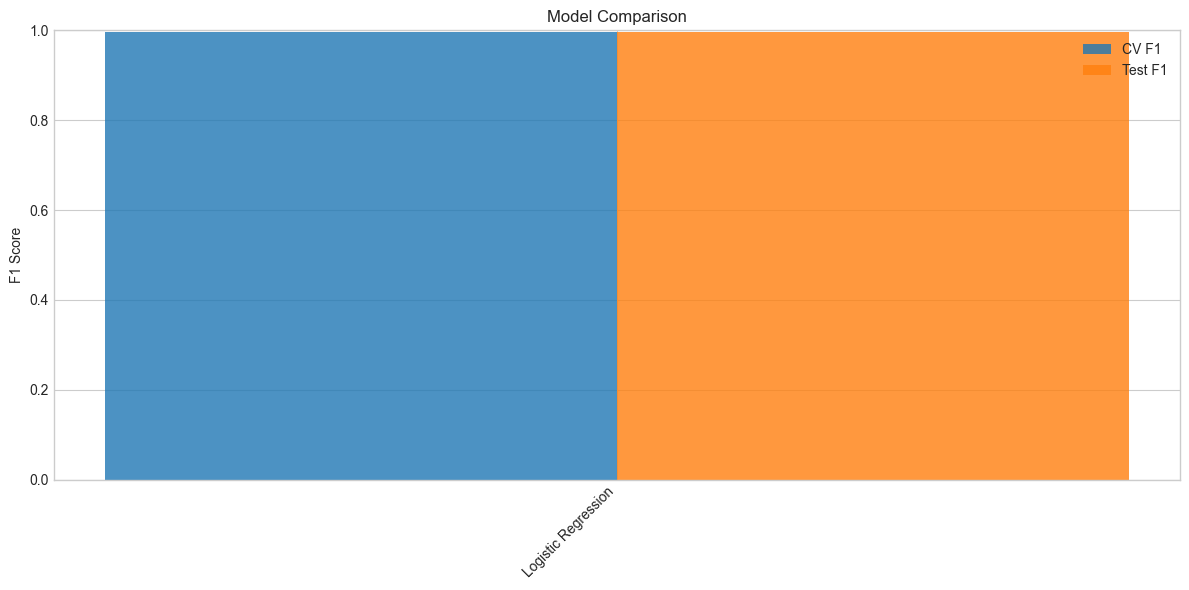

In [29]:
# Visualize results
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results_df))
width = 0.35

ax.bar(x - width/2, results_df['CV F1 Mean'], width, label='CV F1', alpha=0.8)
ax.bar(x + width/2, results_df['Test F1'], width, label='Test F1', alpha=0.8)

ax.set_ylabel('F1 Score')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

## 11. Best Model Analysis

In [30]:
# Select best model
best_name = results_df.iloc[0]['Model']
best_model = models[best_name]

print(f"Best Model: {best_name}")

y_pred = best_model.predict(X_combined_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Best Model: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           N       0.96      0.98      0.97        84
           Y       1.00      1.00      1.00       694

    accuracy                           0.99       778
   macro avg       0.98      0.99      0.98       778
weighted avg       0.99      0.99      0.99       778



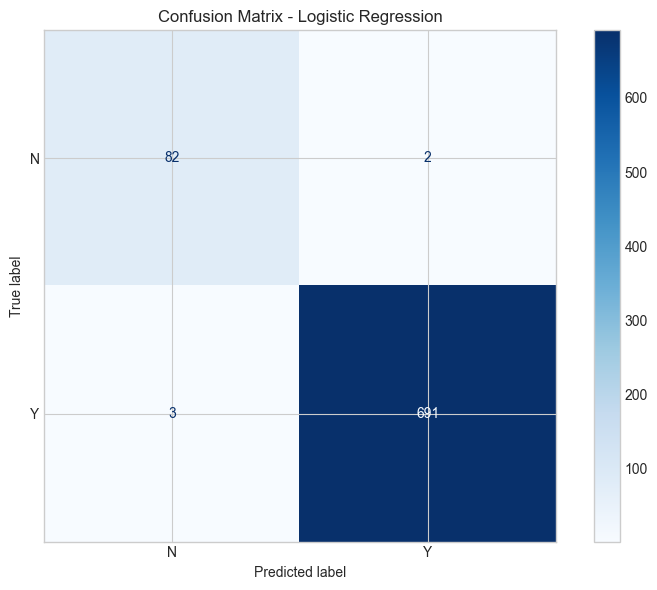

In [31]:
# Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title(f'Confusion Matrix - {best_name}')
plt.tight_layout()
plt.show()

## 12. Unsupervised Clustering (Optional)

Running clustering analysis...

Clustering Metrics:
  Silhouette Score: 0.1281
  Calinski-Harabasz Score: 345.52

Cluster Distribution:
0    258
1    731
2    374
3     25
4     40
5    148
6    817
7    717
Name: count, dtype: int64

Generating t-SNE visualization...


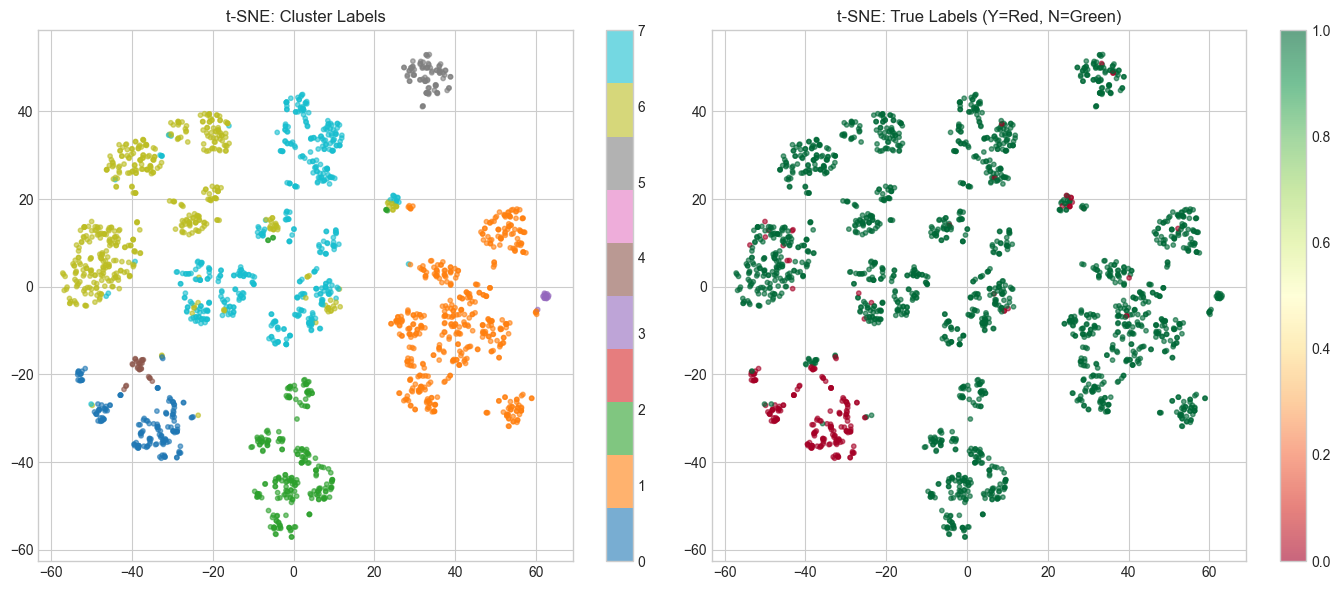

In [32]:
if CONFIG.get('enable_clustering', False):
    print("Running clustering analysis...")
    
    # Reduce dimensionality for clustering
    svd = TruncatedSVD(n_components=100, random_state=42)
    X_reduced = svd.fit_transform(X_combined_train)
    
    # K-Means clustering
    n_clusters = CONFIG['n_clusters']
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_reduced)
    
    # Evaluate clustering
    silhouette = silhouette_score(X_reduced, cluster_labels)
    calinski = calinski_harabasz_score(X_reduced, cluster_labels)
    
    print(f"\nClustering Metrics:")
    print(f"  Silhouette Score: {silhouette:.4f}")
    print(f"  Calinski-Harabasz Score: {calinski:.2f}")
    
    # Cluster distribution
    print(f"\nCluster Distribution:")
    print(pd.Series(cluster_labels).value_counts().sort_index())
    
    # Visualize with t-SNE
    print("\nGenerating t-SNE visualization...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_reduced[:2000])  # Limit for speed
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Clusters
    scatter = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels[:2000], 
                              cmap='tab10', alpha=0.6, s=10)
    axes[0].set_title('t-SNE: Cluster Labels')
    plt.colorbar(scatter, ax=axes[0])
    
    # True labels
    scatter = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train[:2000],
                              cmap='RdYlGn', alpha=0.6, s=10)
    axes[1].set_title('t-SNE: True Labels (Y=Red, N=Green)')
    plt.colorbar(scatter, ax=axes[1])
    
    plt.tight_layout()
    plt.show()
else:
    print("Clustering disabled. Set CONFIG['enable_clustering'] = True to enable.")

## 13. Feature Importance

In [33]:
def get_top_features(model, tfidf_vectorizer, n=30):
    """Get top features from model."""
    feature_names = list(tfidf_vectorizer.get_feature_names_out())
    feature_names.extend(numerical_cols)
    
    if hasattr(model, 'coef_'):
        coef = model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_
        coef = coef[:len(feature_names)]  # Limit to named features
        
        # Top positive (ME = Y)
        top_pos_idx = np.argsort(coef)[-n:]
        top_pos = [(feature_names[i], coef[i]) for i in reversed(top_pos_idx) if i < len(feature_names)]
        
        # Top negative (ME = N)
        top_neg_idx = np.argsort(coef)[:n]
        top_neg = [(feature_names[i], coef[i]) for i in top_neg_idx if i < len(feature_names)]
        
        return top_pos, top_neg
    
    elif hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_[:len(feature_names)]
        top_idx = np.argsort(importance)[-n:]
        top = [(feature_names[i], importance[i]) for i in reversed(top_idx) if i < len(feature_names)]
        return top, []
    
    return [], []

In [34]:
# Get feature importance for best model
if hasattr(best_model, 'coef_') or hasattr(best_model, 'feature_importances_'):
    top_pos, top_neg = get_top_features(best_model, tfidf)
    
    print("Top Features for ME = Y (FBT Subject):")
    print("-" * 50)
    for feat, score in top_pos[:20]:
        print(f"  {feat:35s} {score:+.4f}")
    
    if top_neg:
        print("\nTop Features for ME = N (Not FBT Subject):")
        print("-" * 50)
        for feat, score in top_neg[:20]:
            print(f"  {feat:35s} {score:+.4f}")
else:
    print("Feature importance not available for this model type.")

Top Features for ME = Y (FBT Subject):
--------------------------------------------------
  has_entertainment_kw                +1.1183
  has_travel_kw                       +1.0525
  is_fbt_q4                           +1.0114
  has_client_kw                       +0.7716
  word_count                          +0.7418
  day_of_week                         +0.6811
  has_staff_kw                        +0.4843
  drinks                              +0.4730
  meeting costs                       +0.3721
  staff                               +0.3504
  costs                               +0.3459
  locations_found                     +0.3365
  meals                               +0.3288
  primary_lon                         +0.3183
  ap accruals                         +0.3099
  ap                                  +0.3077
  accruals                            +0.3074
  meeting                             +0.3020
  estimated_travel_hours              +0.2903
  offshore meals                    

## 14. Hyperparameter Tuning

In [35]:
# Grid search for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['saga']
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Running GridSearchCV...")
grid_search.fit(X_combined_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV F1: {grid_search.best_score_:.4f}")

Running GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best CV F1: 0.9960


In [36]:
# Evaluate tuned model
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_combined_test)

print("\nTuned Model Results:")
print(classification_report(y_test, y_pred_tuned, target_names=label_encoder.classes_))


Tuned Model Results:
              precision    recall  f1-score   support

           N       0.98      0.98      0.98        84
           Y       1.00      1.00      1.00       694

    accuracy                           0.99       778
   macro avg       0.99      0.99      0.99       778
weighted avg       0.99      0.99      0.99       778



## 15. Ensemble Model

In [37]:
# Create ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')),
        ('nb', ComplementNB(alpha=0.1)),
        ('svc', CalibratedClassifierCV(LinearSVC(max_iter=2000, random_state=42, class_weight='balanced'))),
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1))
    ],
    voting='soft'
)

print("Training ensemble...")
ensemble.fit(X_combined_train, y_train)

y_pred_ensemble = ensemble.predict(X_combined_test)
print("\nEnsemble Results:")
print(classification_report(y_test, y_pred_ensemble, target_names=label_encoder.classes_))

Training ensemble...


ValueError: Negative values in data passed to ComplementNB (input X).

## 16. Save Model

In [38]:
# Save all components
model_package = {
    'model': ensemble,
    'tfidf': tfidf,
    'scaler': scaler,
    'cat_encoder': cat_encoder if categorical_cols else None,
    'label_encoder': label_encoder,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'config': CONFIG
}

joblib.dump(model_package, CONFIG['model_output'])
print(f"Model saved to: {CONFIG['model_output']}")

Model saved to: fbt_classifier_pipeline.joblib


## 17. Inference Function

In [41]:
def predict_fbt(texts: List[str], features_df: pd.DataFrame = None,
                model_path: str = CONFIG['model_output']) -> pd.DataFrame:
    """
    Predict FBT classification for new expenses.
    """
    # Load model
    pkg = joblib.load(model_path)
    
    # Transform text
    X_tfidf = pkg['tfidf'].transform(texts)
    
    # Handle features
    if features_df is not None:
        X_num = features_df[pkg['numerical_cols']].fillna(0).values
        X_num_scaled = pkg['scaler'].transform(X_num)
        
        if pkg['cat_encoder']:
            X_cat = pkg['cat_encoder'].transform(features_df[pkg['categorical_cols']].fillna('unknown'))
            X_combined = sparse.hstack([X_tfidf, sparse.csr_matrix(X_num_scaled), X_cat])
        else:
            X_combined = sparse.hstack([X_tfidf, sparse.csr_matrix(X_num_scaled)])
    else:
        X_combined = X_tfidf
    
    # Predict
    predictions = pkg['model'].predict(X_combined)
    labels = pkg['label_encoder'].inverse_transform(predictions)
    
    # Probabilities
    if hasattr(pkg['model'], 'predict_proba'):
        probs = pkg['model'].predict_proba(X_combined)
        prob_y = probs[:, 1]  # Probability of Y (ME)
    else:
        prob_y = np.nan
    
    return pd.DataFrame({
        'text': texts,
        'prediction': labels,
        'prob_ME': prob_y
    })

In [42]:
# Test inference
test_texts = [
    "client dinner at restaurant melbourne 5 partners",
    "taxi to airport business trip brisbane",
    "team building activity bowling sydney",
    "training seminar registration fee",
    "christmas party catering staff 50 people",
    "flight to roma client visit farm",
    "lunch meeting with client local cafe"
]

predictions = predict_fbt(test_texts)
print("\nSample Predictions:")
print(predictions.to_string(index=False))

AttributeError: 'VotingClassifier' object has no attribute 'estimators_'

## 18. Summary

In [43]:
print("=" * 60)
print("PIPELINE SUMMARY")
print("=" * 60)
print(f"\nData:")
print(f"  Raw samples: {len(raw_data_clean)}")
print(f"  Labeled samples: {len(train_df)}")
print(f"  Training samples: {len(X_text_train)}")
print(f"  Test samples: {len(X_text_test)}")
print(f"\nFeatures:")
print(f"  TF-IDF features: {X_tfidf_train.shape[1]}")
print(f"  Numerical features: {len(numerical_cols)}")
print(f"  Categorical features: {len(categorical_cols)}")
print(f"  Total features: {X_combined_train.shape[1]}")
print(f"\nBest Model: {best_name}")
print(f"  Test F1: {results_df.iloc[0]['Test F1']:.4f}")
print(f"\nLocation Features:")
print(f"  Locations database: {len(AUSTRALIAN_LOCATIONS)} entries")
print(f"  Samples with locations: {(labeled_features['locations_found'] > 0).sum()}")
print(f"\nSaved:")
print(f"  Model: {CONFIG['model_output']}")

PIPELINE SUMMARY

Data:
  Raw samples: 33616
  Labeled samples: 3888
  Training samples: 3110
  Test samples: 778

Features:
  TF-IDF features: 5000
  Numerical features: 37
  Categorical features: 4
  Total features: 5077

Best Model: Logistic Regression
  Test F1: 0.9964

Location Features:
  Locations database: 174 entries
  Samples with locations: 10883

Saved:
  Model: fbt_classifier_pipeline.joblib
